In [ ]:
!pip install scipy
!pip install Levenshtein
!pip install matplotlib
!pip install seaborn

In [ ]:
import json
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
import Levenshtein
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load data 
file_name = "results_FCGPT_qwen2.5_32b-instruct-q4_K_M.json"
path = "filtered_results/" + file_name
with open(path, 'r') as file:
    generated = json.load(file)

if 'FCGPT' in file_name:
    with open('data/dataset_FCGPT.json', 'r') as file:
        ground_truth = json.load(file)
else:
    with open('data/dataset_comments.json', 'r') as file:
        ground_truth = json.load(file)


In [ ]:
# Process dataset to organize claims by comment and remove the sources that are not in both datasets
gt_comments = []
for entry in ground_truth:
    #if file_name contains FCGPT
    if 'FCGPT' in file_name:
        claims = []
        for item in entry.get('claims', []):
            if isinstance(item, list):
                claims.extend(item)
            elif isinstance(item, dict):
                claims.append(item.get('claim', ''))
            elif isinstance(item, str):
                claims.append(item)
        gt_comments.append(claims)
    else:
        claims = entry.get('claim', [])
        gt_comments.append(claims)


loki_comments = []
for entry in generated:
    claims = []
    for item in entry.get('claims', []):
        if isinstance(item, list):
            claims.extend(item)
        elif isinstance(item, dict):
            claims.append(item.get('claim', ''))
        elif isinstance(item, str):
            claims.append(item)
    loki_comments.append(claims)


print(f"Number of GT claims: {len(gt_comments)}")
print(f"Number of generated claims: {len(loki_comments)}")

Number of GT claims: 94
Number of generated claims: 94


In [100]:
# Function to compute normalized similarity from edit distance
def compute_edit_similarity(reference, candidate):
    # Get raw Levenshtein distance
    edit_distance = Levenshtein.distance(reference, candidate)

    # Normalize by the length of the longer string
    max_len = max(len(reference), len(candidate))
    if max_len == 0:  # Handle empty strings
        return 1.0

    # Convert to similarity (1 - normalized distance)
    similarity = 1 - (edit_distance / max_len)
    return similarity


In [101]:
# Comment-based evaluation
all_scores = []
all_pairs = []
comment_metrics = []
threshold = 0.7

for i, (gt_claims_comment, gen_claims_comment) in enumerate(zip(gt_comments, loki_comments)):
    # Skip empty comments
    if not gt_claims_comment or not gen_claims_comment:
        continue

    # Create similarity matrix for this comment
    num_gt = len(gt_claims_comment)
    num_gen = len(gen_claims_comment)

    # Handle unequal number of claims
    max_claims = max(num_gt, num_gen)
    similarity_matrix = np.zeros((max_claims, max_claims))

    # Fill similarity matrix (missing claims get 0 similarity)
    for i_idx in range(min(num_gt, max_claims)):
        for j_idx in range(min(num_gen, max_claims)):
            similarity_matrix[i_idx, j_idx] = compute_edit_similarity(gt_claims_comment[i_idx], gen_claims_comment[j_idx])

    # Apply Hungarian algorithm
    cost_matrix = -similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Get valid matches (ignoring padding)
    matches = [(r, c) for r, c in zip(row_ind, col_ind)]
    valid_matches = [(r, c) for r, c in zip(row_ind, col_ind)
                     if r < num_gt and c < num_gen]

    if not valid_matches:
        continue

    # Calculate metrics for this comment
    comment_scores = [similarity_matrix[r, c] for r, c in valid_matches]
    # Calculate average of all pairs with non empty generated claims
    comment_scores_strict = [similarity_matrix[r, c] for r, c in matches]
    avg_score = np.mean(comment_scores)
    avg_score_strict = np.mean(comment_scores_strict)

    # Track matched pairs
    comment_pairs = [
        {
            'Comment_Index': i,
            'GT_Claim': gt_claims_comment[r] if r < num_gt else " ",
            'Generated_Claim': gen_claims_comment[c] if c < num_gen else " ",
            'Score': similarity_matrix[r, c]
        }
        for r, c in zip(row_ind, col_ind)
    ]

    # Calculate comment-level metrics
    good_matches = sum(1 for score in comment_scores if score >= threshold)
    recall = good_matches / num_gt if num_gt > 0 else 0
    precision = good_matches / num_gen if num_gen > 0 else 0
    good_matches_strict = sum(1 for score in comment_scores_strict if score >= threshold)

    # Add comment metrics
    comment_metrics.append({
        'Comment_Index': i,
        'Avg_Score': avg_score,
        'Recall': recall,
        'Precision': precision,
        'Avg_Score_Strict': avg_score_strict,
        'GT_Claims': num_gt,
        'Gen_Claims': num_gen,
        'Good_Matches': good_matches,
        'Good_Matches_Strict': good_matches_strict,
    })

    # Add to overall scores and pairs
    all_scores.extend(comment_scores)
    all_pairs.extend(comment_pairs)

# Convert to DataFrame for easier analysis
df_metrics = pd.DataFrame(comment_metrics)

# Overall metrics
overall_avg_score = np.mean(all_scores)
overall_recall = np.mean(df_metrics['Recall'])
overall_precision = np.mean(df_metrics['Precision'])
overall_avg_score_strict = np.mean(df_metrics['Avg_Score_Strict'])
overall_good_matches = np.sum(df_metrics['Good_Matches'])
overall_good_matches_strict = np.sum(df_metrics['Good_Matches_Strict'])

print(f"Overall Average Score (Edit Distance): {overall_avg_score:.3f}")
print(f"Overall Recall (Edit Distance): {overall_recall:.2%}")
print(f"Overall Precision (Edit Distance): {overall_precision:.2%}")

Overall Average Score (Edit Distance): 0.515
Overall Recall (Edit Distance): 16.96%
Overall Precision (Edit Distance): 23.75%


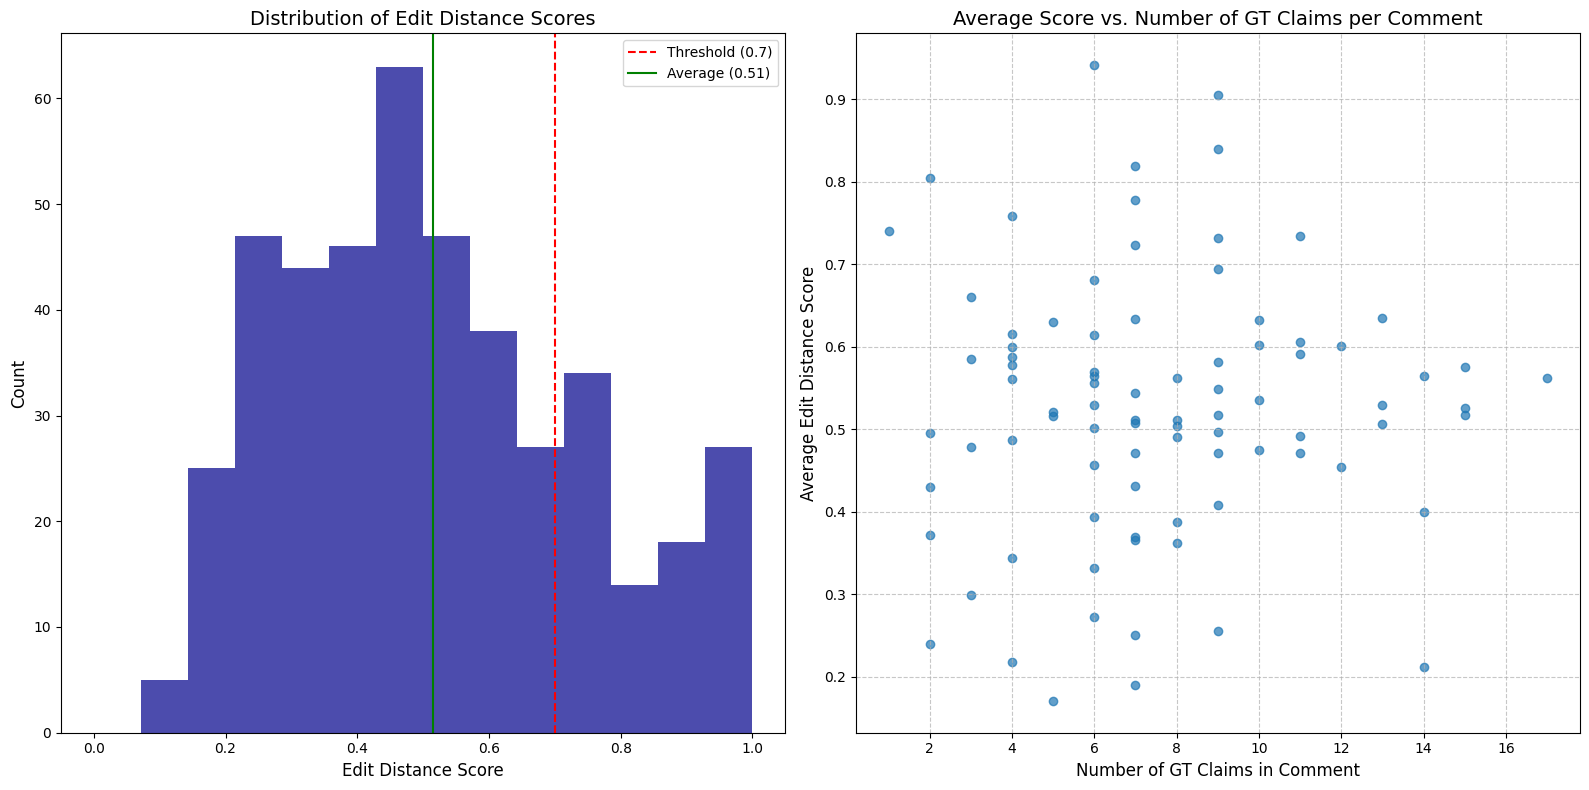

In [102]:
# Visualization
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Distribution of scores
bins = np.linspace(0, 1, 15)
ax1.hist(all_scores, bins=bins, color='darkblue', alpha=0.7)
ax1.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
ax1.axvline(x=overall_avg_score, color='green', linestyle='-', label=f'Average ({overall_avg_score:.2f})')
ax1.set_title('Distribution of Edit Distance Scores', fontsize=14)
ax1.set_xlabel('Edit Distance Score', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.legend()

# Per-comment metrics
ax2.scatter(df_metrics['GT_Claims'], df_metrics['Avg_Score'], alpha=0.7)
ax2.set_title('Average Score vs. Number of GT Claims per Comment', fontsize=14)
ax2.set_xlabel('Number of GT Claims in Comment', fontsize=12)
ax2.set_ylabel('Average Edit Distance Score', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
results = [file_name, overall_avg_score, overall_recall, overall_precision, overall_avg_score_strict, overall_good_matches, overall_good_matches_strict]
df_results = pd.DataFrame([results], columns=['File_Name', 'Overall_Avg_Score', 'Overall_Recall', 'Overall_Precision', 'Overall_Avg_Score_Strict', 'Overall_Good_Matches', 'Overall_Good_Matches_Strict'])

file_pairs =  "edit_pairs_" + file_name
# Save the matched pairs to a JSON file
with open(file_pairs, 'w') as f:
    json.dump(all_pairs, f, indent=4)
# Save the metrics to a CSV file
f.close()

file_metrics =  "edit_metrics_" + file_name
# Save the matched pairs to a JSON file
with open(file_metrics, 'w') as f:
    json.dump(comment_metrics, f, indent=4)
# Save the metrics to a CSV file
f.close()



with open('results.csv', 'a') as f:
    df_results.to_csv(f, header=f.tell() == 0, index=False)
f.close()

